# Mixture Model (Coffees dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

import sys, IPython, matplotlib, platform
print("This notebook was created on a %s computer running %s using:\nPython v%s\nIPython \
v%s\nPyMC3 v%s\nNumPy v%s\nMatplotlib v%s\nSeaborn v%s\nPandas v%s\nArviz v%s" % (platform.machine(), \
' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, \
np.__version__, matplotlib.__version__, sns.__version__, pd.__version__, az.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This notebook was created on a x86_64 computer running Ubuntu 18.04 using:
Python v3.6.8
IPython v7.8.0
PyMC3 v3.7
NumPy v1.17.3
Matplotlib v3.1.1
Seaborn v0.9.0
Pandas v0.25.2
Arviz v0.5.1


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/coffees/FTIR_instant_coffees.csv', 'label', -2)
data = data_obj.data
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
5,13.165349,13.587405,13.998584,13.476876,12.577613,11.989945,11.243600,10.692459,10.469784,10.374012,...,2.044999,2.023647,2.008715,1.990087,1.965167,1.953658,1.942450,1.930312,1,Arabica
33,14.108081,14.476337,14.516783,14.074631,13.217934,12.466894,11.724800,11.070709,10.706896,10.565004,...,1.896521,1.876392,1.852087,1.830727,1.813216,1.798814,1.783991,1.776107,2,Robusta
13,13.438294,13.687354,14.090918,13.742180,12.870400,12.025635,11.451002,11.097792,10.680395,10.490485,...,2.128728,2.106235,2.090319,2.074972,2.056196,2.039637,2.026209,2.019408,1,Arabica
19,11.708212,12.189027,12.115101,11.461263,10.624787,9.845979,9.528569,9.187627,8.901355,8.872402,...,1.934408,1.914148,1.901100,1.887963,1.871052,1.855958,1.838835,1.827901,1,Arabica


Arabica: blue
Robusta: red


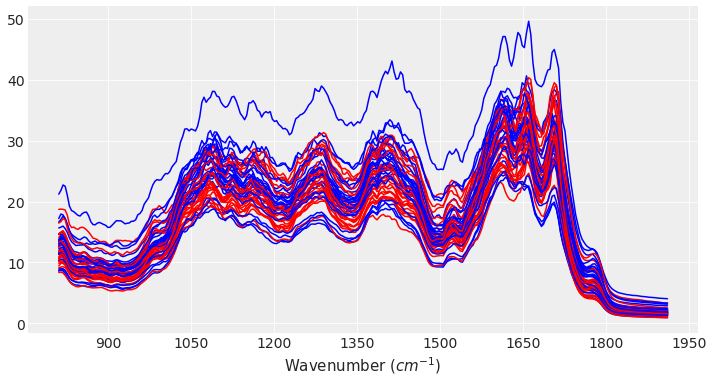

In [4]:
# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 50)

In [5]:
# number of samples from each class
data[data_obj.label_column].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [6]:
# array of class codes
idx = np.array(pd.Categorical(data[data_obj.label_column]).codes, dtype='int')

# number of classes
classes = len(np.unique(idx))

# data array
x_n = data.columns[:data_obj.non_data_columns]
x_s = data[x_n].values
x_s.shape

(56, 286)

# Model definition

The following statistical model is assumed:

\begin{equation}
\mu_x \sim U(0, max(Y)) \\
\sigma_{s} \sim \Gamma(1, 1) \\
\sigma_{x} \sim |\mathcal{N}(0, \sigma^{2}_{s})| \\
X_0 \sim \mathcal{N}(\mu_x,\,\sigma^{2}_{x}) \\
X_1 \sim \mathcal{N}(\mu_x,\,\sigma^{2}_{x}) \\
\sigma_{\epsilon} \sim \Gamma(1, 1) \\
\epsilon_{x} \sim |\mathcal{N}(0,\,\sigma^{2}_{\epsilon})| \\
\theta \sim Beta(1,1) \\
Y \sim Bernoulli(\theta) \\
X = \begin{cases}X_0 + \epsilon_x & \text{if } Y = 0 \\X_1 + \epsilon_x & \text{if } Y = 1\end{cases}
\end{equation}

In [7]:
with pm.Model() as model_mm:
    mu_x = pm.Uniform('mu_x', 0, x_s.max())
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma_x = pm.HalfNormal('sigma_x', sigma_s)
    
    #x_0 = pm.Normal('x_0', mu=mu_x, sd=sigma_x, shape=len(x_n))
    #x_1 = pm.Normal('x_1', mu=mu_x, sd=sigma_x, shape=len(x_n))
    x = pm.Normal('x', mu=mu_x, sd=sigma_x, shape=(classes,len(x_n)))
    
    # labels 0 or 1 (observed from the data)
    #theta = pm.Beta('theta', 1, 1)
    #label = pm.Bernoulli('label', p=theta, observed=Yl) 
    
    # switch to spectrum 0 or 1 depending on the label
    #x = pm.math.switch(pm.math.eq(label, 1), x_0, x_1)
    
    # random noise on top of observation
    sigma_e = pm.Gamma('sigma_e', alpha=1., beta=1.)
    epsilon_x = pm.HalfNormal('epsilon_x', sigma_e)
    
    y_pred = pm.Normal('y_pred', mu=x[idx], sd=epsilon_x, observed=x_s)
    
    trace_mm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon_x, sigma_e, x, sigma_x, sigma_s, mu_x]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:05<00:00, 76.19draws/s] 


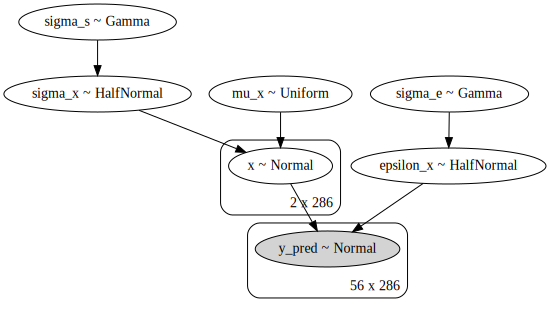

In [8]:
pm.model_to_graphviz(model_mm)

In [9]:
az.summary(trace_mm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"x[0,0]",13.069,0.616,11.961,14.298,0.006,0.004,11176.0,11041.0,11208.0,2363.0,1.0
"x[0,1]",13.345,0.600,12.237,14.443,0.006,0.004,9327.0,9327.0,9270.0,2643.0,1.0
"x[0,2]",13.394,0.613,12.250,14.570,0.007,0.005,8446.0,8334.0,8504.0,2468.0,1.0
"x[0,3]",12.959,0.599,11.882,14.093,0.006,0.004,9850.0,9797.0,9808.0,2304.0,1.0
"x[0,4]",12.207,0.605,11.095,13.361,0.006,0.004,9548.0,9426.0,9504.0,2603.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_x,17.249,0.351,16.569,17.903,0.003,0.002,12504.0,12504.0,12690.0,2438.0,1.0
sigma_s,4.360,1.292,2.268,6.673,0.018,0.015,5298.0,3720.0,8330.0,2593.0,1.0
sigma_x,8.149,0.250,7.695,8.627,0.003,0.002,9523.0,9308.0,9734.0,2653.0,1.0
sigma_e,2.520,0.997,1.085,4.374,0.014,0.013,5298.0,3023.0,10187.0,2667.0,1.0


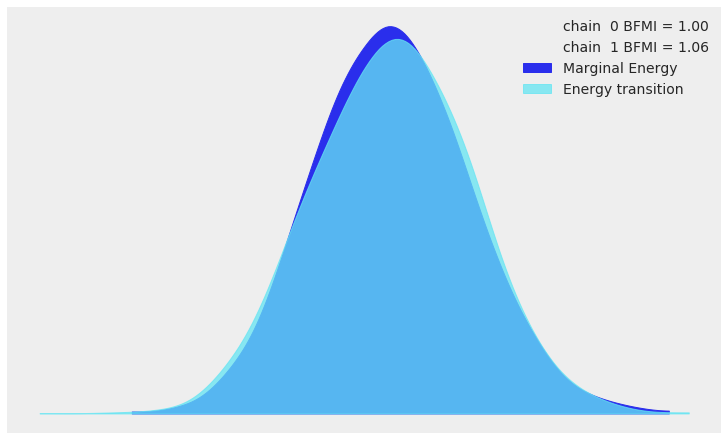

In [10]:
az.plot_energy(trace_mm, figsize=(10, 6));

In [11]:
ppc = pm.sample_posterior_predictive(trace_mm, samples=250, model=model_mm)

100%|██████████| 250/250 [00:00<00:00, 393.66it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


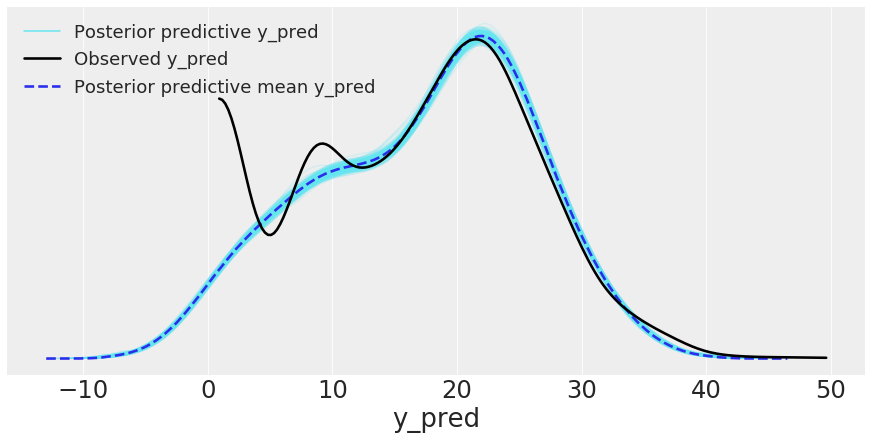

In [12]:
data_ppc = az.from_pymc3(trace=trace_mm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [13]:
az.r2_score(x_s, ppc['y_pred'])

r2        0.856046
r2_std    0.011074
dtype: float64

In [14]:
print(az.bfmi(trace_mm))

[0.99919791 1.05718768]


In [28]:
print(az.loo(trace_mm))

Computed from 4000 by 16016 log-likelihood matrix

       Estimate       SE
IC_loo 84199.34   266.01
p_loo    557.99        -


In [29]:
print(az.waic(trace_mm))

Computed from 4000 by 16016 log-likelihood matrix

        Estimate       SE
IC_waic 84197.98   265.99
p_waic    557.31        -

There has been a warning during the calculation. Please check the results.


/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


# Posterior samples vs. mean data

In [24]:
# class samples from the posterior
cl_a = ppc['y_pred']

ppc_class_lst = [cl_a]

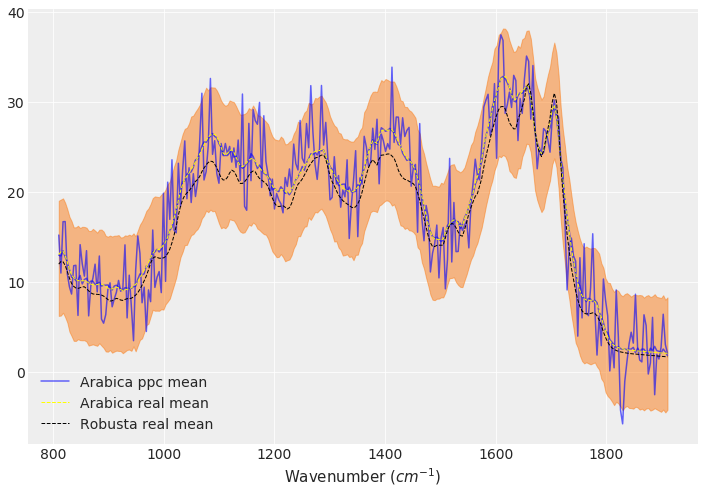

In [25]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

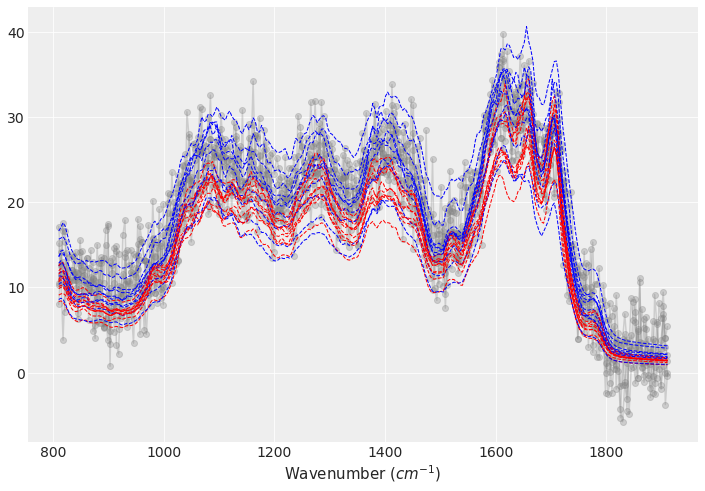

In [26]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 10)